In [1]:
using StatsPlots, Turing, Distributions, Random

# Probability of a girl birth given placenta previa

An early study concerning the sex of placenta previa births in Germany found that of a total of 980 births, 437 were female. How much evidence does this provide for the claim that the proportion of female births in the population of placenta previa births is less than 0.485, the proportion of female births in the general population?

In [2]:
p0 = 0.485
n = 980
k = 437
;

In [3]:
@model function placenta_previa(n0, n, k)
    α0 = n0*p0
    β0 = n0 - α0
    p ~ Beta(α0, β0)
	k ~ Binomial(n, p)
end

placenta_previa (generic function with 1 method)

## Simulator

It would better to re-use the code, but not an option with Turing.

In [6]:
function placenta_previa_sim(n0, n; nsamples=100)
    α0 = n0*p0
    β0 = n0 - α0
    ps = rand(Beta(α0, β0), nsamples)
    vcat([rand(Binomial(n, p), 1) for p in ps]...)
end

placenta_previa_sim (generic function with 1 method)

We should decide about the weight of the prior evidence.  The minimum prior evidence is 2 (we'll learn later why).

In [56]:
n0 = 50

50

## Prior predictive

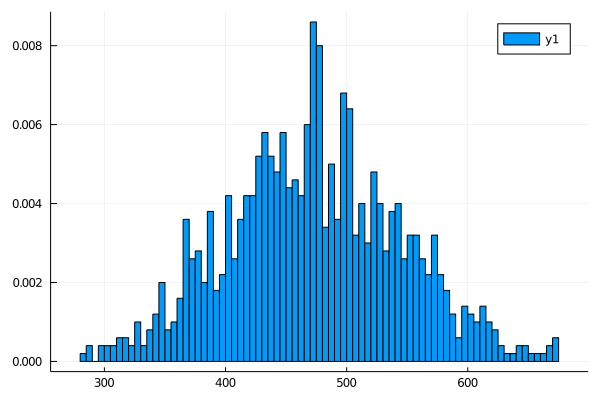

In [57]:
predictive_prior = placenta_previa_sim(n0, n, nsamples=1000)
histogram(predictive_prior, bins=100, normalize=true)

In [58]:
describe(predictive_prior)

Summary Stats:
Length:         1000
Missing Count:  0
Mean:           472.556000
Minimum:        284.000000
1st Quartile:   425.000000
Median:         472.000000
3rd Quartile:   521.000000
Maximum:        674.000000
Type:           Int64


In [59]:
chns = sample(placenta_previa(n0, n, k), HMC(0.1, 5), 10000)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×10×1 Array{Float64,3}):

Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = p
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, n_steps, nom_step_size, step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat 
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64 

           p    0.4478    0.0154     0.0002    0.0001   67811.8855    0.9999

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           p    0.4182    0.4371    0.4477    0.4581    0.4781


## Posterior

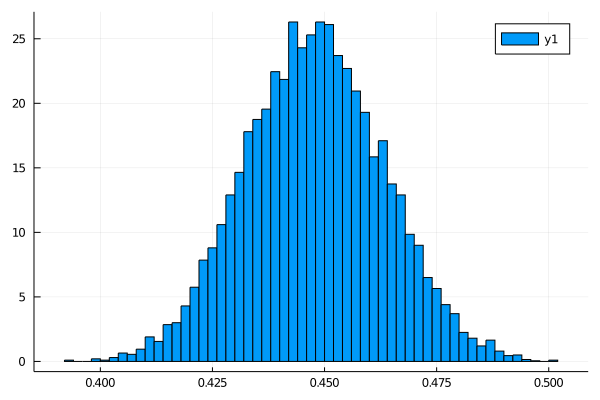

In [60]:
posterior = chns[:p].data[:, 1]
histogram(posterior, normalize=true)

In [61]:
describe(posterior)

Summary Stats:
Length:         10000
Missing Count:  0
Mean:           0.447781
Minimum:        0.392465
1st Quartile:   0.437121
Median:         0.447744
3rd Quartile:   0.458135
Maximum:        0.501021
Type:           Float64


## Predictive posterior

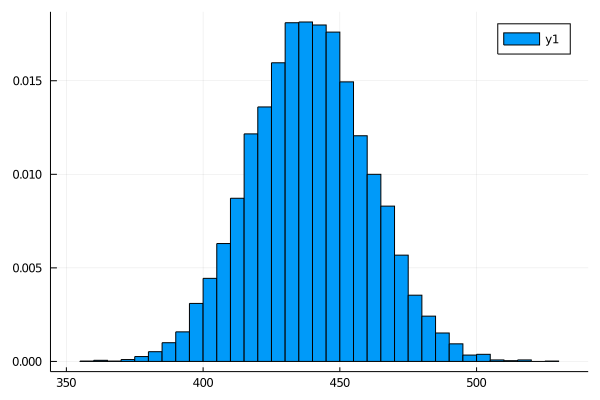

In [62]:
predictive_posterior = vcat([rand(Binomial(n, p), 1) for p in posterior]...)
histogram(predictive_posterior, normalize=true)

In [63]:
describe(predictive_posterior)

Summary Stats:
Length:         10000
Missing Count:  0
Mean:           438.545200
Minimum:        359.000000
1st Quartile:   424.000000
Median:         439.000000
3rd Quartile:   453.000000
Maximum:        526.000000
Type:           Int64


Let's plot the predictive prior and predictive posterior overlayed.

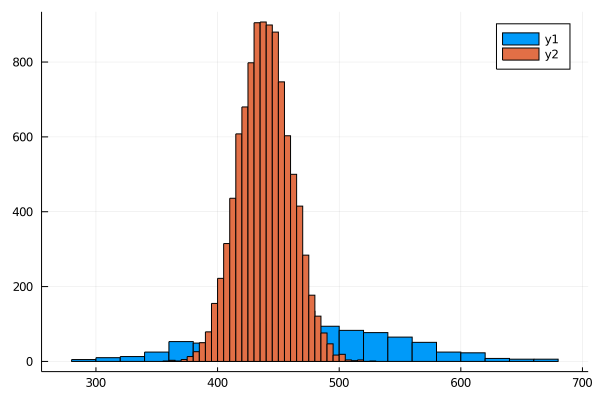

In [64]:
histogram(predictive_prior)
histogram!(predictive_posterior)

## Probability $p=p_0$ under normal approximation

In [65]:
1 - cdf(Normal(mean(posterior), std(posterior)), p0)

0.007754115652941818

## Compatibility intervals

In [66]:
"Computes the compatibility interval"
function interval(data; p=0.95)
    data = sort(data)
    low = Int64(round(length(data)*0.5*(1-p)))
    high = Int64(round(length(data)*0.5*(1+p)))
    return data[low], data[high]
end

interval

In [67]:
interval(posterior)

(0.4182180778546311, 0.4780703265834924)

In [68]:
interval(predictive_posterior)

(398, 481)

In [69]:
interval(predictive_prior)

(335, 613)

In [70]:
980*0.485

475.3